In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import cv2
import os
import imghdr
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
data_dir = "/content/drive/MyDrive/SampleMaizeD"

In [4]:
for image_class in os.listdir(data_dir):
  print(image_class)

Healthy
MLB
MSV


In [5]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=100

**LOADING DATA INTO A KERAS API PIPELINE**

In [6]:
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE)

Found 3000 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names

['Healthy', 'MLB', 'MSV']

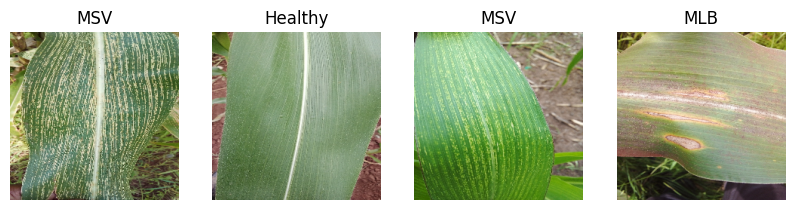

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(4):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
dataset = dataset.map(lambda x,y: (x/255, y))

**Spliting the Dataset Into Train, Test and Validation**

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
len(train_ds)

75

In [13]:
len(val_ds)

9

In [14]:
len(test_ds)

10

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# **PREPROCESSING**

# **MobileNet V2**

In [16]:
inputShape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
base_model = tf.keras.applications.MobileNetV2(input_shape=inputShape,
                                               input_tensor=None,
                                               include_top=False,
                                               weights='imagenet')

NameError: ignored

In [17]:
base_model.trainable = False

In [18]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [ ]:
'''fine_tune_at = 144
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False'''

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
#dropout_layer = tf.keras.layers.Dropout(0.2)
prediction_layer = tf.keras.layers.Dense(3, activation = "softmax")

In [21]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  #dropout_layer,
  prediction_layer
])

In [22]:
#model.summary()

NameError: ignored

In [23]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.optimizer.lr=0.001

In [24]:
#Early_stop= tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [25]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs= EPOCHS,
    #callbacks=[Early_stop]
)

Epoch 1/100
75/75 [==============================] - 475s 937ms/step - loss: 0.4969 - accuracy: 0.8098 - val_loss: 0.2383 - val_accuracy: 0.9271
Epoch 2/100
75/75 [==============================] - 3s 47ms/step - loss: 0.2313 - accuracy: 0.9218 - val_loss: 0.1726 - val_accuracy: 0.9340
Epoch 3/100
75/75 [==============================] - 4s 50ms/step - loss: 0.1782 - accuracy: 0.9473 - val_loss: 0.1495 - val_accuracy: 0.9375
Epoch 4/100
75/75 [==============================] - 3s 46ms/step - loss: 0.1549 - accuracy: 0.9519 - val_loss: 0.1386 - val_accuracy: 0.9514
Epoch 5/100
75/75 [==============================] - 3s 46ms/step - loss: 0.1338 - accuracy: 0.9536 - val_loss: 0.1237 - val_accuracy: 0.9514
Epoch 6/100
75/75 [==============================] - 4s 50ms/step - loss: 0.1191 - accuracy: 0.9632 - val_loss: 0.1017 - val_accuracy: 0.9653
Epoch 7/100
75/75 [==============================] - 4s 53ms/step - loss: 0.1036 - accuracy: 0.9678 - val_loss: 0.0937 - val_accuracy: 0.9688
Epo

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

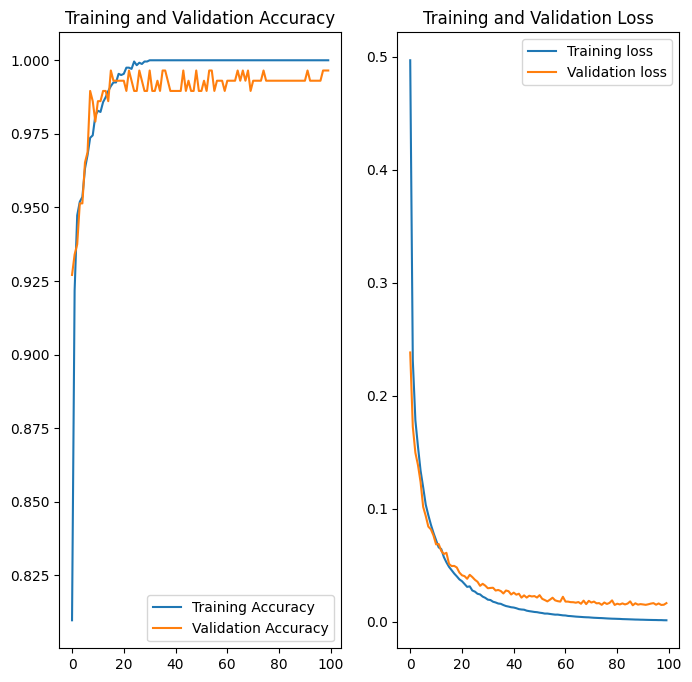

In [27]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc ='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation loss')
plt.legend(loc ='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
#scores = model.evaluate(test_ds)

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0])
    print(np.argmax(batch_prediction[0]))
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [30]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        
        plt.axis("off")

In [32]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as pyplot

In [33]:
def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=pyplot.cm.Blues
):
    
    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=45)
    pyplot.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, "{:0.2f}".format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')

In [34]:
target_names = ["Healthy", "MLB", "MSV"]

In [35]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 42ms/step


In [36]:
print("Confusion Matrix")
conf_matrix = confusion_matrix(correct_labels, predicted_labels)
print(conf_matrix)

Confusion Matrix
[[106   1   0]
 [  1 111   1]
 [  0   0 100]]


Confusion matrix, without normalization
[[106   1   0]
 [  1 111   1]
 [  0   0 100]]


<function matplotlib.pyplot.show(close=None, block=None)>

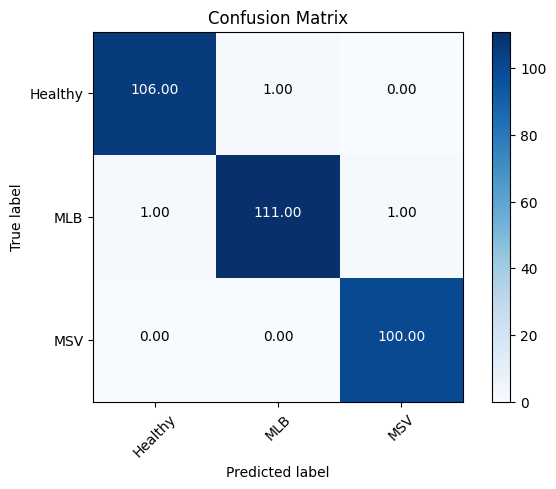

In [37]:
pyplot.figure(1)
plot_confusion_matrix(conf_matrix, classes=target_names, normalize=False, title="Confusion Matrix")
pyplot.show

In [38]:
print(classification_report(correct_labels, predicted_labels, target_names=target_names))

              precision    recall  f1-score   support

     Healthy       0.99      0.99      0.99       107
         MLB       0.99      0.98      0.99       113
         MSV       0.99      1.00      1.00       100

    accuracy                           0.99       320
   macro avg       0.99      0.99      0.99       320
weighted avg       0.99      0.99      0.99       320



In [39]:
#model.save('/content/drive/MyDrive/Models/model.mobnet_8_trainable.h5') # Saves the entire model to a single artifact